<a href="https://colab.research.google.com/github/AnjaDeric/MDA-TeamCroatia/blob/main/SymptomResultPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID Symptoms: Test Result Prediction

In this notebook, we create and test some machine learning models to predict the outcome of a COVID test result based on information like one's gender, travel status, and symptoms.

## Setup

For this task, we will be using pycaret, which is an open-source library that automates machine learning workflows. We fist install pycaret and all other necesarry libraries and packages.

In [1]:
! pip install pycaret
! pip install markupsafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.0.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (31 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Succes

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pycaret.classification import *
import itertools

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Initial Exploratory Analysis and Cleaning

Next, we load in and clean up the data we will be using. The data was downladed from a peer-reviewed [npj Digital Medicine article](https://www.nature.com/articles/s41746-020-00372-6). 

In [3]:
# load in data
url = 'https://raw.githubusercontent.com/AnjaDeric/MDA-TeamCroatia/main/Data/covid_symptom_test_data.csv'
symptoms = pd.read_csv(url)
symptoms.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,4/30/2020,0,0,0,0,0,negative,None,female,Other
1,4/30/2020,1,0,0,0,0,negative,None,female,Other
2,4/30/2020,0,1,0,0,0,negative,None,male,Other
3,4/30/2020,1,0,0,0,0,negative,None,female,Other
4,4/30/2020,1,0,0,0,0,negative,None,male,Other


Since our dashboard will require the user to check or uncheck all columns, we drop all symptom-related rows with 'None' as the value.

In [4]:
for col_name in ['cough','fever','sore_throat','shortness_of_breath','head_ache']:
  # drop rows with 'None'
  symptoms = symptoms[symptoms[col_name] != 'None']
  # convert to numeric binary column
  symptoms[col_name] = pd.to_numeric(symptoms[col_name])
  print(symptoms[col_name].value_counts())
  print()

0    236368
1     42228
Name: cough, dtype: int64

0    256843
1     21751
Name: fever, dtype: int64

0    276672
1      1922
Name: sore_throat, dtype: int64

0    277020
1      1574
Name: shortness_of_breath, dtype: int64

0    276186
1      2408
Name: head_ache, dtype: int64



We change all 'None' values in the 60 and above category to missing values.

In [5]:
symptoms.loc[symptoms['age_60_and_above'] == 'None', 'age_60_and_above'] = np.NaN
symptoms['age_60_and_above'].value_counts()

No     125504
Yes     25775
Name: age_60_and_above, dtype: int64

We change all 'None' values in the gender category to missing values.

In [6]:
symptoms.loc[symptoms['gender'] == 'None', 'gender'] = np.NaN
symptoms['gender'].value_counts()

female    130030
male      129012
Name: gender, dtype: int64

If a patient did not go abroad or have a close contact, we set the test_indication category to missing.

In [7]:
symptoms.loc[symptoms['test_indication'] == 'Contact with confirmed', 'test_indication'] = 'contact'
symptoms.loc[symptoms['test_indication'] == 'Other', 'test_indication'] = np.NaN
symptoms['test_indication'].value_counts()

Abroad     25462
contact    10628
Name: test_indication, dtype: int64

We drop all rows for which we do not know the outcome of the COVID test result.

In [8]:
# drop cases where we don't know the COVID test results
symptoms = symptoms[symptoms['corona_result'] != 'other']
symptoms['corona_result'].value_counts()

negative    260008
positive     14694
Name: corona_result, dtype: int64

We drop the test date from the data set as we will not be using it in model building steps.

In [9]:
symptoms.drop('test_date', axis=1, inplace=True)

## Modeling

We can now move forward to the modeling step. We first check the final format of our data.

In [10]:
symptoms.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,0,0,0,0,0,negative,NaN,female,NaN
1,1,0,0,0,0,negative,NaN,female,NaN
2,0,1,0,0,0,negative,NaN,male,NaN
3,1,0,0,0,0,negative,NaN,female,NaN
4,1,0,0,0,0,negative,NaN,male,NaN


We split our data into a training and test set, with 90% being used for training (will futher be split into training and validation by pycaret), and 10% being used for final testing.

In [11]:
x = symptoms.loc[:, symptoms.columns != 'corona_result']
y = symptoms.loc[:, symptoms.columns == 'corona_result']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

Next, we set up our models. Every model will be using the same data, so we specify the following:


*   **categorical_imputation**: categorical variables with missing values will be set to 'not_available'
*   **categorical_imputation**: specifying to treat all variables as categorical
*   **fix_imbalance**: since we have 260k negative cases and only 15k positive cases, SMOTE (Synthetic Minority Over-sampling Technique) is applied to balance the traning data
*   **remove_outliers**: remove traning set outliers using Singular Value Decomposition
*   **remove_multicollinearity**: remove features with the inter-correlations higher than the defined threshold
*   **multicollinearity_threshold**: set the threshold for multicollinearity to 0.9



In [12]:
exp1 = setup(data = pd.concat([x_train, y_train], axis=1), 
             target = 'corona_result',
             categorical_imputation = 'constant',
             categorical_features = ['cough','fever','sore_throat','shortness_of_breath','head_ache','age_60_and_above','gender','test_indication'],
             fix_imbalance = True,
             remove_outliers = True,
             feature_interaction = True,
             remove_multicollinearity = True,
             multicollinearity_threshold = 0.9,
             log_plots = True,
             log_data = True,
             profile= True) 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Next, we compare initally trained model to pick best-performing ones.

In [13]:
top_models = compare_models(fold = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.9729,0.7092,0.4266,0.6376,0.5112,0.4978,0.5085,0.652
knn,K Neighbors Classifier,0.9727,0.7769,0.3929,0.6486,0.4885,0.4753,0.4916,252.448
dummy,Dummy Classifier,0.9668,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.422
ada,Ada Boost Classifier,0.9042,0.8472,0.6580,0.2056,0.3133,0.2767,0.3318,5.786
nb,Naive Bayes,0.8979,0.8473,0.6490,0.1925,0.2969,0.2590,0.3157,0.500
ridge,Ridge Classifier,0.8963,0.0000,0.6659,0.1928,0.2989,0.2609,0.3205,0.492
lda,Linear Discriminant Analysis,0.8963,0.8463,0.6659,0.1928,0.2989,0.2609,0.3205,1.742
lr,Logistic Regression,0.8942,0.8474,0.6838,0.1926,0.3005,0.2623,0.3252,1.860
dt,Decision Tree Classifier,0.8927,0.8570,0.7210,0.1968,0.3091,0.2711,0.3397,0.596
rf,Random Forest Classifier,0.8927,0.8569,0.7210,0.1968,0.3091,0.2711,0.3397,9.304


We pick which models to tune further by choosing a few models with high AUC and high recall metrics. Since the test prediction is only supposed to serve as guidance (not as a formal COVID test result), we want to correctly classify as many of the positive cases as possible, even at the risk of misclassifying a lot of negative cases (in other words, better safe than sorry!). This is why we prioritize high recall.

Based on these requirements, the models we choose to tune further are Logistic Regression, Random Forest, and Gradient Booster.

### Logistic Regression Model

In [23]:
lr_model = create_model('lr')
lr_tuned = tune_model(lr_model, n_iter=10, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8875,0.8430,0.6868,0.1826,0.2885,0.2491,0.3150
1,0.8890,0.8415,0.6685,0.1816,0.2856,0.2462,0.3091
2,0.8952,0.8463,0.6954,0.1957,0.3054,0.2675,0.3317
3,0.8963,0.8506,0.6612,0.1918,0.2974,0.2592,0.3183
4,0.8946,0.8399,0.6832,0.1930,0.3009,0.2628,0.3254
5,0.8921,0.8395,0.6722,0.1871,0.2927,0.2539,0.3161
6,0.8955,0.8389,0.6740,0.1929,0.2999,0.2618,0.3229
7,0.8945,0.8529,0.7106,0.1975,0.3090,0.2712,0.3377
8,0.8984,0.8644,0.7125,0.2045,0.3178,0.2807,0.3458


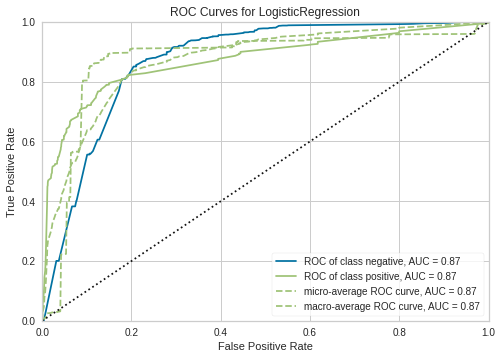

In [26]:
plot_model(lr_tuned, plot = 'auc')

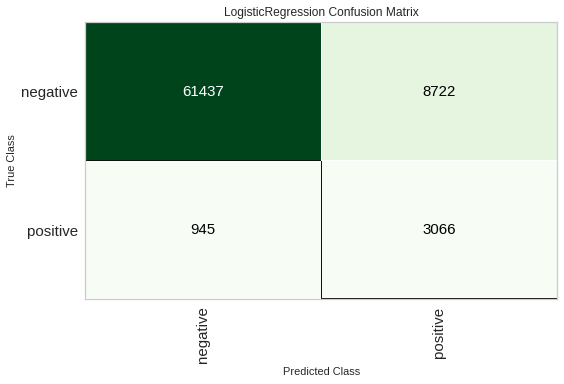

In [27]:
plot_model(lr_tuned, plot = 'confusion_matrix')

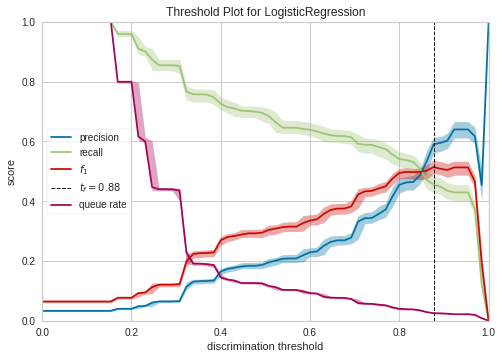

In [28]:
plot_model(lr_tuned, plot = 'threshold')

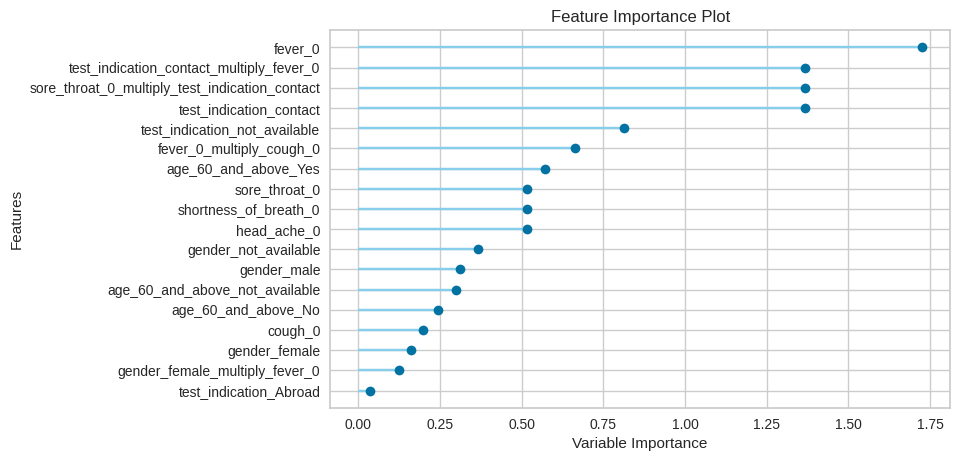

In [30]:
plot_model(lr_tuned, plot = 'feature_all')

In [31]:
plot_model(lr_tuned, plot = 'parameter')

,Parameters
C,9.682
class_weight,balanced
dual,False
fit_intercept,True
intercept_scaling,1
l1_ratio,None
max_iter,1000
multi_class,auto
n_jobs,None
penalty,l2


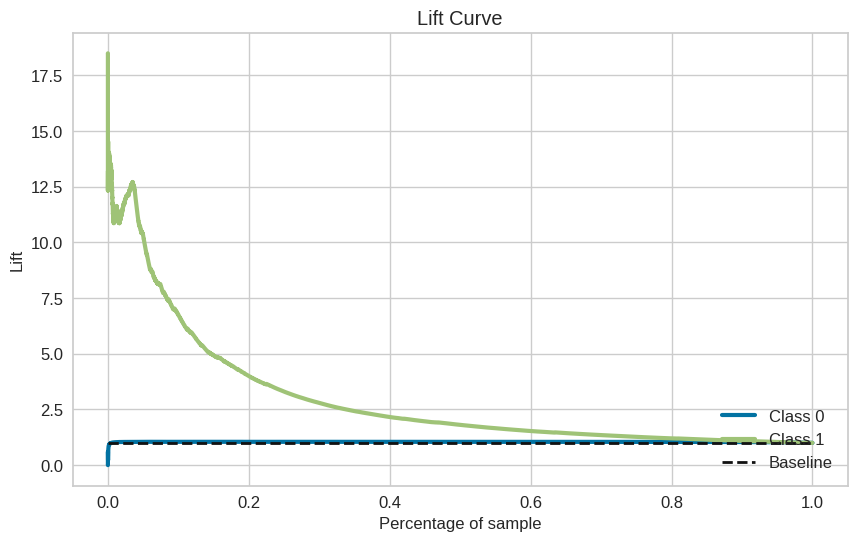

In [32]:
plot_model(lr_tuned, plot = 'lift')

In [24]:
lr_final = finalize_model(lr_tuned)

In [25]:
save_model(lr_final, 'best_LR')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['cough', 'fever',
                                                             'sore_throat',
                                                             'shortness_of_breath',
                                                             'head_ache',
                                                             'age_60_and_above',
                                                             'gender',
                                                             'test_indication'],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='corona_result',
                                       time_features=[])),
                 (

### Gradient Boosting Model

In [14]:
gbc_model = create_model('gbc')
gbc_tuned = tune_model(gbc_model, n_iter=10, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8929,0.8569,0.7143,0.1955,0.3070,0.2688,0.3366
1,0.8936,0.8529,0.7088,0.1958,0.3068,0.2687,0.3354
2,0.8846,0.8514,0.7413,0.1870,0.2987,0.2595,0.3343
3,0.8867,0.8685,0.7234,0.1875,0.2978,0.2587,0.3301
4,0.8935,0.8505,0.7253,0.1982,0.3113,0.2734,0.3425
5,0.8848,0.8449,0.7088,0.1824,0.2901,0.2505,0.3205
6,0.8988,0.8447,0.6850,0.2004,0.3101,0.2728,0.3339
7,0.8876,0.8664,0.7491,0.1929,0.3068,0.2682,0.3430
8,0.8976,0.8728,0.7509,0.2094,0.3275,0.2906,0.3615


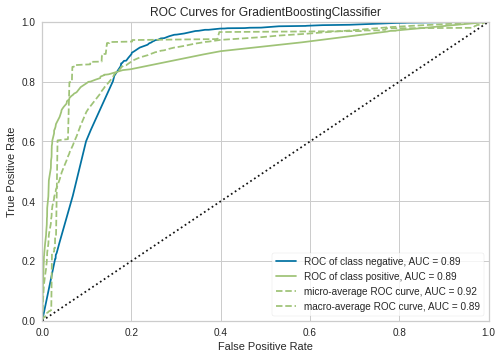

In [15]:
plot_model(gbc_tuned, plot = 'auc')

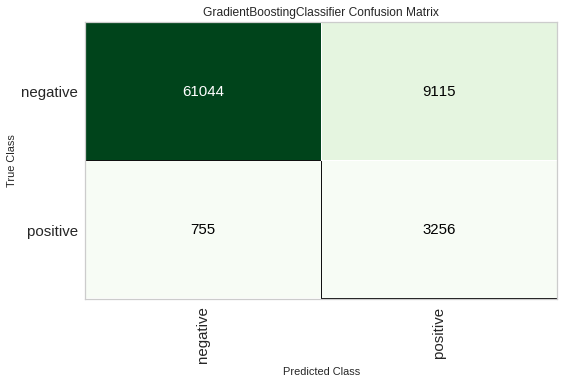

In [18]:
plot_model(gbc_tuned, plot = 'confusion_matrix')

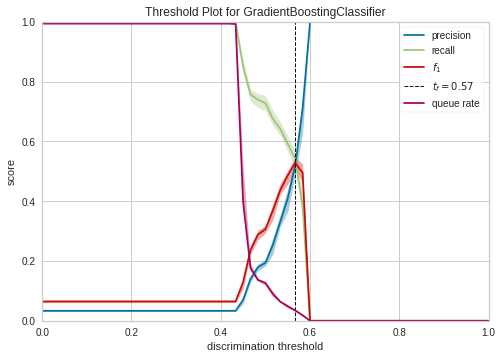

In [19]:
plot_model(gbc_tuned, plot = 'threshold')

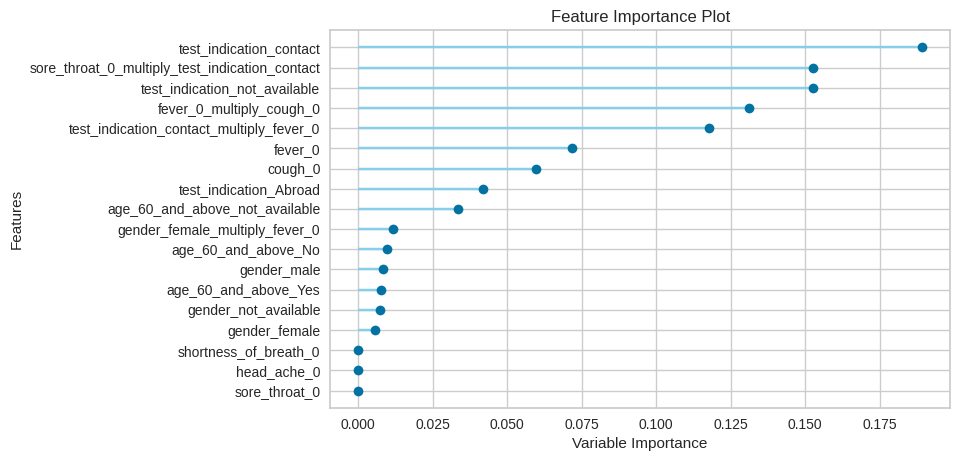

In [20]:
plot_model(gbc_tuned, plot = 'feature_all')

In [21]:
plot_model(gbc_tuned, plot = 'parameter')

,Parameters
ccp_alpha,0.0
criterion,friedman_mse
init,None
learning_rate,0.005
loss,deviance
max_depth,11
max_features,log2
max_leaf_nodes,None
min_impurity_decrease,0.2
min_impurity_split,None


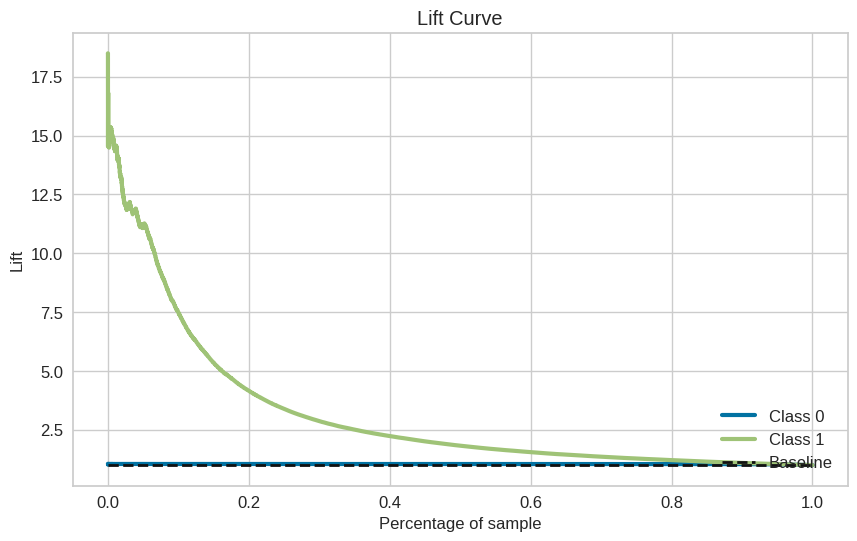

In [22]:
plot_model(gbc_tuned, plot = 'lift')

In [16]:
gbc_final = finalize_model(gbc_tuned)

In [17]:
save_model(gbc_final, 'best_GBC')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['cough', 'fever',
                                                             'sore_throat',
                                                             'shortness_of_breath',
                                                             'head_ache',
                                                             'age_60_and_above',
                                                             'gender',
                                                             'test_indication'],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='corona_result',
                                       time_features=[])),
                 (

### Random Forest Model

In [33]:
rf_model = create_model('rf')
rf_tuned = tune_model(rf_model, n_iter=10, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8857,0.8532,0.7253,0.1863,0.2964,0.2572,0.3292
1,0.8831,0.8523,0.7216,0.1821,0.2908,0.2511,0.3234
2,0.8833,0.8535,0.7431,0.1854,0.2968,0.2574,0.3330
3,0.8862,0.8647,0.7234,0.1867,0.2968,0.2576,0.3292
4,0.8855,0.8494,0.7326,0.1872,0.2982,0.2590,0.3321
5,0.8834,0.8488,0.7106,0.1806,0.2880,0.2482,0.3190
6,0.8972,0.8479,0.6868,0.1979,0.3073,0.2696,0.3317
7,0.8868,0.8649,0.7491,0.1917,0.3052,0.2664,0.3415
8,0.8968,0.8756,0.7527,0.2083,0.3263,0.2894,0.3609


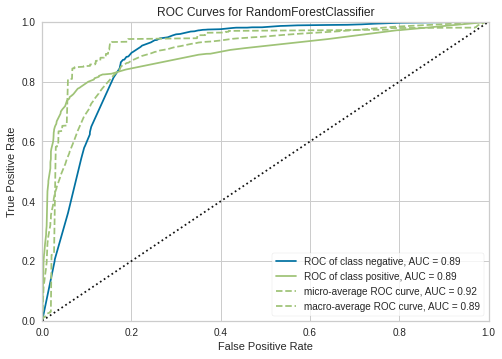

In [34]:
plot_model(rf_tuned, plot = 'auc')

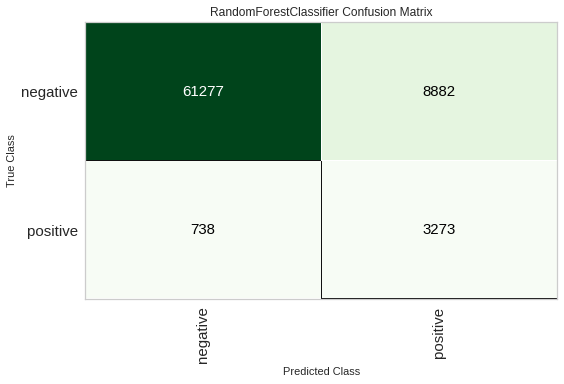

In [37]:
plot_model(rf_tuned, plot = 'confusion_matrix')

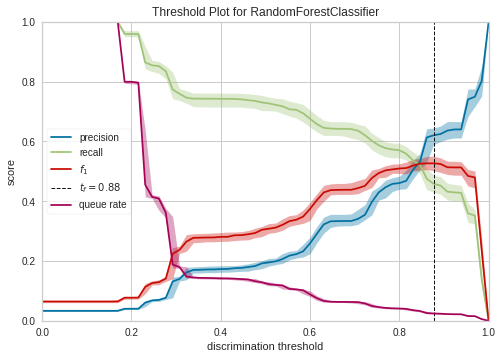

In [38]:
plot_model(rf_tuned, plot = 'threshold')

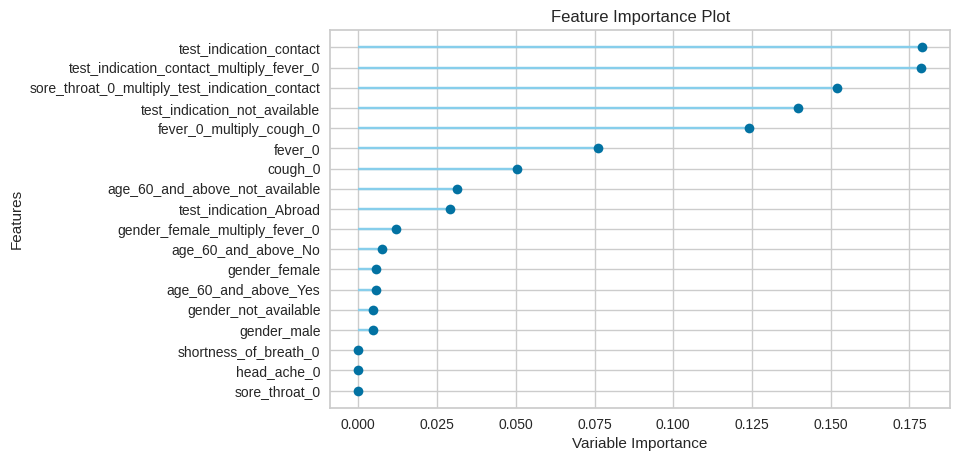

In [39]:
plot_model(rf_tuned, plot = 'feature_all')

In [40]:
plot_model(rf_tuned, plot = 'parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
class_weight,balanced
criterion,gini
max_depth,6
max_features,log2
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0
min_impurity_split,None


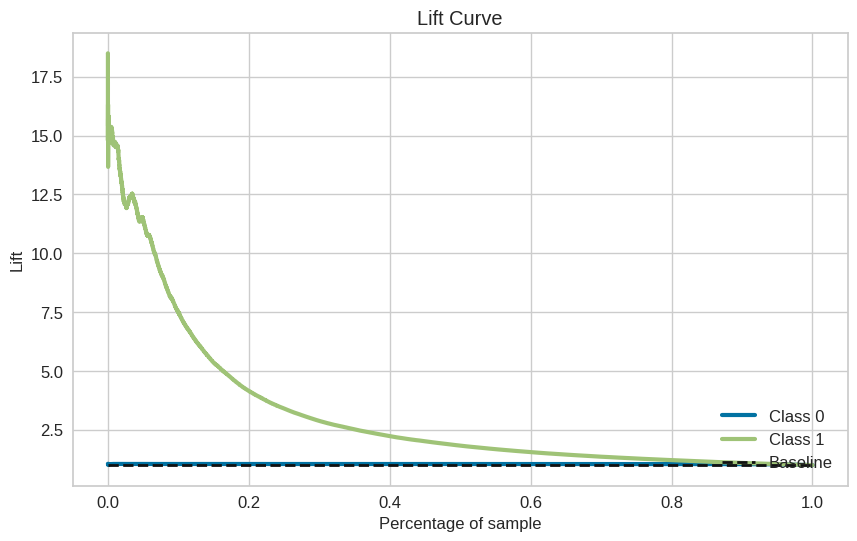

In [41]:
plot_model(rf_tuned, plot = 'lift')

In [35]:
rf_final = finalize_model(rf_tuned)

In [36]:
save_model(rf_final, 'best_RF')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['cough', 'fever',
                                                             'sore_throat',
                                                             'shortness_of_breath',
                                                             'head_ache',
                                                             'age_60_and_above',
                                                             'gender',
                                                             'test_indication'],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='corona_result',
                                       time_features=[])),
                 (

### Testing

Test all models using validation data.

In [70]:
test_data = x_test.copy()
x_test['corona_result'] = y_test
test_data.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,corona_result
172818,0,0,0,0,0,Yes,male,NaN,negative
28513,0,0,0,0,0,NaN,male,NaN,negative
242640,1,1,0,1,0,Yes,male,Abroad,positive
55428,0,0,0,0,0,NaN,male,NaN,negative
216046,0,0,0,0,0,No,female,NaN,negative


In [71]:
test_lr = predict_model(lr_final, data=test_data, raw_score=True)
test_gbc = predict_model(gbc_final, data=test_data, raw_score=True)
test_rf = predict_model(rf_final, data=test_data, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0,0.8881,0,0,0,0,0


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0,0.9054,0,0,0,0,0


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0,0.8988,0,0,0,0,0


Calculate accuracy and recall metrics for validation data.

In [86]:
for test_data in [test_lr,test_gbc,test_rf]:
  conf_matrix = pd.crosstab(test.corona_result, test_data.Label)
  accuracy = (conf_matrix['positive'][1] + conf_matrix['negative'][0])/conf_matrix.sum().sum() 
  recall = conf_matrix['positive'][1]/(conf_matrix['negative'][1] + conf_matrix['positive'][1])
  print(accuracy)
  print(recall)
  print()

0.9055003458192276
0.7540407589599438

0.9202795675439555
0.7835558678847505

0.8942521204178953
0.8095572733661279



# Final Model Results (Export for Dashboard)

Calculate prediction for all possible symptom combinations for all models.

In [46]:
options = {"cough":[0,1], "fever":[0,1], "sore_throat":[0,1], "shortness_of_breath":[0,1],'head_ache':[0,1],'age_60_and_above':['Yes','No'],
 'gender':['male','female'],'test_indication':['abroad','contact','']}

In [47]:
all_options = pd.DataFrame(list(itertools.product(*options.values())), columns=options.keys())

In [48]:
all_options.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication
0,0,0,0,0,0,Yes,male,abroad
1,0,0,0,0,0,Yes,male,contact
2,0,0,0,0,0,Yes,male,
3,0,0,0,0,0,Yes,female,abroad
4,0,0,0,0,0,Yes,female,contact


In [51]:
predictions_lr = predict_model(lr_final, data=all_options, raw_score=True)
predictions_gbc = predict_model(gbc_final, data=all_options, raw_score=True)
predictions_rf = predict_model(rf_final, data=all_options, raw_score=True)

In [52]:
all_options['predictions_lr'] = predictions_lr['Score_positive']
all_options['predictions_gbc'] = predictions_gbc['Score_positive']
all_options['predictions_rf'] = predictions_rf['Score_positive']
all_options.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,predictions_lr,predictions_gbc,predictions_rf
0,0,0,0,0,0,Yes,male,abroad,0.9815,0.5878,0.982
1,0,0,0,0,0,Yes,male,contact,0.9815,0.5878,0.982
2,0,0,0,0,0,Yes,male,,0.9815,0.5878,0.982
3,0,0,0,0,0,Yes,female,abroad,0.9745,0.5879,0.983
4,0,0,0,0,0,Yes,female,contact,0.9745,0.5879,0.983


In [53]:
all_options.to_csv('all_predictions.csv')